<a href="https://colab.research.google.com/github/thijsgelton/P9-Group7_VariationalAutoEncoder/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision Spring
Variational autoencoders practical
```

```
Group number: 7
Student 1 name/number: Marit Hagens, s4808061
Student 2 name/number: Joost Verhaert, s1047220
Student 3 name/number: Thijs Gelton, s4480783
```


#1. Install MXnet GPU and import libraries

In [2]:
!pip install mxnet-cu100

     |████████████████████████████████| 352.6MB 47kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
from mxnet import nd, gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import math
from tqdm.notebook import tqdm

%matplotlib inline

# Feel free to import other modules/packages

## 1.1 Set device context to gpu.

In [4]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)

gpu = gpu_device()

if gpu:
    print('Using GPU for model_ctx')
    model_ctx = gpu
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using GPU for model_ctx


#2. Loading in the MNIST dataset.

In [5]:
# Fixing the random seed
mx.random.seed(42)

# Get data
mnist = mx.test_utils.get_mnist()

In [6]:
# Create data iterators
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'].reshape(-1, 784), mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'].reshape(-1, 784), mnist['test_label'], batch_size)

#3. Develop the Variational Auto-Encoder model

### Task 1 (10 points):

* Implement the decoder class for a variational autoencoder.

---o---

Recall that the decoder transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents. Note that it should output the Gaussian parameters (mean and variance per pixel) of images rather than images themselves.

---o---

In [7]:
class Decoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens = 400, observables = 784, layers = 1, **kwargs):
        super(Decoder, self).__init__(prefix = 'decoder', **kwargs)
        for i in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(observables * 2, activation="sigmoid"))       
        

### Task 2 (10 points):

* Implement the encoder class for a variational autoencoder.

---o---

Recall that the encoder transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables. Note that it should output the Gaussian parameters (mean and variance per feature) of features rather than features themselves.

---o---

In [8]:
class Encoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens= 400, latents = 2, layers = 1, **kwargs): # Feel free to use different arguments
        super(Encoder, self).__init__(prefix = "encoder", **kwargs)
        for i in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(latents * 2)) # No activation function, because mean and std can be [-inf, +inf]

### Task:

* Implement the loss function class for a variational autoecoder.

---o---

The loss function takes the following arguments as input:

* x        : input images (mini batch)
* x_mean   : mean of the decoded images (output of the decoder)
* x_log_var: mean of the decoded images (output of the decoder)
* z_mean   : mean of the encoded features (output of the encoder)
* z_log_var: log variance of the encoded features (output of the encoder)

It gives the following evidence lower bound (ELBO) as ouput:

* $L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

where

* The first term is the KL divergence between the approximate Gaussian posterior (q) and the standard Gaussian prior (p), which can be interpreted as a form of regularization.
* The second term is the Gaussian negative log likelihood, which is the term that fits the data and is very similar to the usual loss functions that are usded in deep learning.

---o---

In [9]:
class Lossfun:
    def __init__(self, w = 0.5):
        self.w = w

    def __call__(self, x, x_mean, x_log_var, z_mean, z_log_var):
        return nd.mean(self.get_kl(z_mean, z_log_var) + self.get_nll(x, x_mean, x_log_var))

    def get_kl(self, z_mean, z_log_var):
        return -0.5 * nd.sum(1 + z_log_var-z_mean**2 - nd.exp(z_log_var), axis=-1)

    def get_nll(self, x, x_mean, x_log_var):
        x_prec = nd.exp(-x_log_var)
        x_diff = x - x_mean
        x_power = -0.5 * nd.square(x_diff) * x_prec
        loss = -0.5 * (x_log_var + np.log(2 * np.pi)) + x_power
        return -nd.sum(loss, axis=-1)

### Task (5 points):

* Implement the variational autoencoder.

In [15]:
class VariationalAutoencoder(gluon.HybridBlock):
    def __init__(self,  activation = "relu", hiddens= 400, latents = 2, observables = 784, layers = 1, **kwargs): # Feel free to use different arguments
        super(VariationalAutoencoder, self).__init__()
        self.latents = latents
        with self.name_scope():
            self.encoder = Encoder(activation, hiddens, latents, layers, **kwargs)
            self.decoder = Decoder(activation, hiddens, observables, layers, **kwargs)

    def hybrid_forward(self, F, x):
        z_mean, z_log_var = F.split(self.encoder(x), axis=1, num_outputs=2)

        eps = F.random_normal(loc=0, scale=1, shape=(x.shape[0], self.latents), ctx=model_ctx) # Reparamitisation trick
        z = z_mean + F.exp(0.5 * z_log_var) * eps
        
        x_mean, x_log_var = F.split(self.decoder(z), axis=1, num_outputs=2)
        return x, x_mean, x_log_var, z_mean, z_log_var

### Task (25 points):

* Train the variational autoencoder on the Mnist dataset. You can refer to the previous assignment to implement your training loop.

In [16]:
# check wheter there is a gpu and use the best option
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
vae_model = VariationalAutoencoder()
loss_fn = Lossfun()
vae_model.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(vae_model.collect_params(), 'adam', {'learning_rate': 0.002})

In [17]:
import time
n_epoch = 100
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []

for i in tqdm(range(n_epoch), desc='epochs'):
    # Reset the train data iterator.
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    # Loop over the train data iterator.
    for batch in train_data:
        n_batch_train +=1
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = batch.data[0].as_in_context(model_ctx)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        # label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            z = vae_model(data)
            # Computes softmax cross entropy loss.
            loss = loss_fn(*z)
        loss.backward()
        trainer.step(batch.data[0].shape[0])
        epoch_loss += nd.mean(loss).asscalar()

        # Backpropagate the error for one iteration.
        outputs.append(z)

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        z = vae_model(data)
        loss = loss_fn(*z)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if i % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {}, Validation loss {}'.format(i, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 749.8251387532553, Validation loss 743.6416552734376
Epoch10, Training loss 742.139228515625, Validation loss 742.1616839599609
Epoch20, Training loss 741.7181458536784, Validation loss 741.6983758544922
Epoch30, Training loss 741.4722135416666, Validation loss 741.5545916748047
Epoch40, Training loss 741.3129289754232, Validation loss 741.4123406982421
Epoch50, Training loss 741.1992979939779, Validation loss 741.3590240478516
Epoch60, Training loss 741.1068361409506, Validation loss 741.3356927490235
Epoch70, Training loss 741.0356782023111, Validation loss 741.2835375976563
Epoch80, Training loss 740.9998181152343, Validation loss 741.3015826416016
Epoch90, Training loss 740.9413917032878, Validation loss 741.2137072753907

Time elapsed: 387.88s


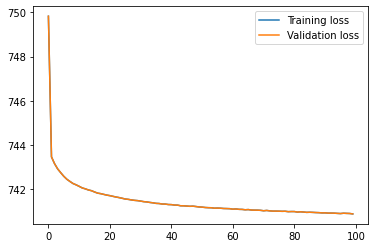

In [18]:
plt.plot(training_loss, label="Training loss")
plt.plot(training_loss, label="Validation loss")
plt.legend()
plt.show()

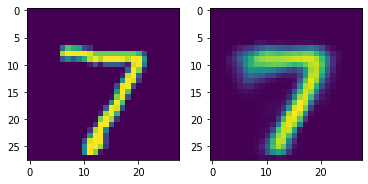

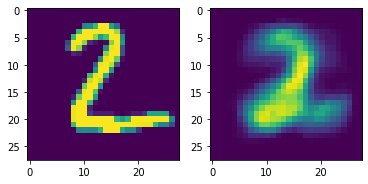

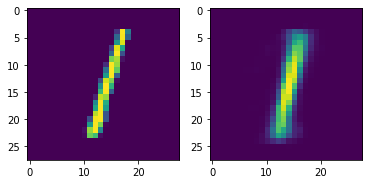

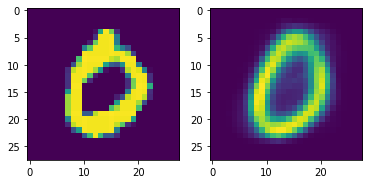

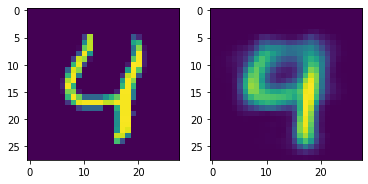

In [19]:
for test_img in mnist["test_data"][0:5, 0]:
    plt.subplot(1, 2, 1)
    plt.imshow(test_img)
    x, x_mean, x_log_var, z_mean, z_log_var = vae_model(nd.array(test_img.reshape(1, 784)).as_in_context(model_ctx))
    plt.subplot(1, 2, 2)
    plt.imshow(x_mean[0].asnumpy().reshape(28,28))
    plt.show()

### Task (50 points):
* Evaluate the reconstruction quality of the variational autoencoder: Draw some Mnist like images, encode them, decode them, visualize them and briefly explain the results.

Text(0.5, 0.7, 'Reconstructed images')

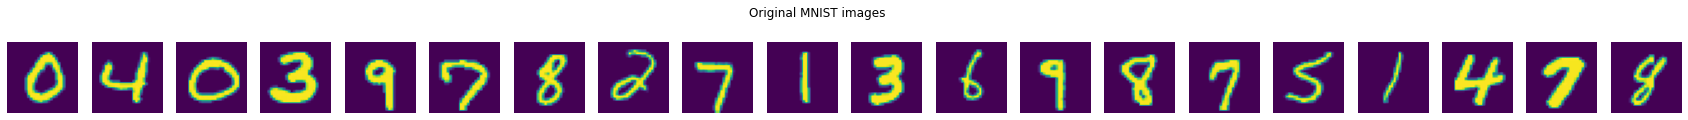

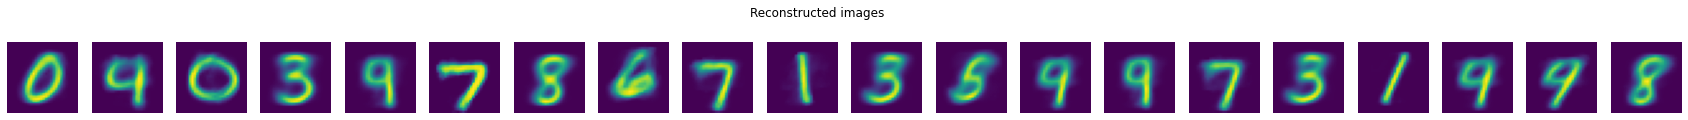

In [24]:
# Draw indices of some MNIST images
n_images = 20
idx = np.random.choice(mnist['test_data'].shape[0], n_images)
# Plot images
fig, ax = plt.subplots(1, n_images, figsize=(30, 5))
for i, j in enumerate(idx):
    ax[i].imshow(mnist["test_data"][j, 0])
    ax[i].axis("off")
plt.suptitle('Original MNIST images', y=0.7)


# Plot reconstructions
fig, ax = plt.subplots(1, n_images, figsize=(30, 5))
for i, j in enumerate(idx):
    ax[i].imshow(vae_model(nd.array(mnist["test_data"][j, 0].reshape(1, 784)).as_in_context(model_ctx))[1].asnumpy().reshape(28, 28))
    ax[i].axis("off")
plt.suptitle('Reconstructed images', y=0.7)


*Above we drew some MNIST images and encode, decoded, and visualized them. The top row shows the original MNIST images and the bottom row are the reconstructions created by the VAE.*

*This shows that the VAE is quite good at reconstructing the MNIST images. Overall, the reconstruction creates the same digit as the input digit. However, it does also make mistakes. Mistakes that are often made is turning a 4 or 7 into a 9. This is due to how the 4 and 7 are written, when the 4 is written like an upside down 'h' and the 7 like '7', it can be turned into a 9 by only adding 1 line. This makes it easy for the VAE to make this mistake. Another mistake is changing the 3 into an 8 and the other way around. This happens because the 3 and 8 both have the same kind of roundings, which makes them very similar and easy to exchange.*

*Next, we will see how the VAE responds to different drawings. For this we will use drawings of clothing from the FashionMNIST dataset.*
 
 
 * Repeat the task with drawings of something else (e.g., a face).

Text(0.5, 0.7, 'Reconstructed images')

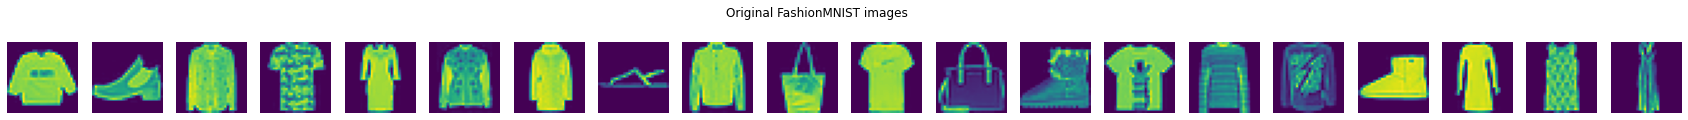

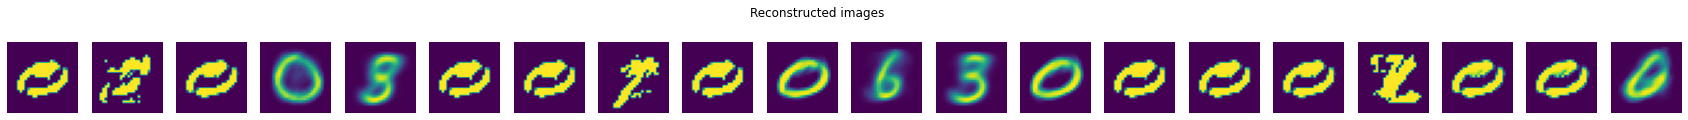

In [30]:
from mxnet.gluon.data.vision import datasets, transforms

# Read in drawings
mnist_fashion = datasets.FashionMNIST(train=True)

# Draw images from FashionMNIST dataset
# idx = np.random.choice(len(mnist_fashion), n_images)
X, _ = mnist_fashion[0:n_images]
# Plot images
fig, ax = plt.subplots(1, n_images, figsize=(30, 5))
for i, x in enumerate(X):
    ax[i].imshow(x.reshape((28,28)).asnumpy())
    ax[i].axis("off")
plt.suptitle('Original FashionMNIST images', y=0.7)


# Plot reconstructions of FashionMNIST images
fig, ax = plt.subplots(1, n_images, figsize=(30, 5))
for i, x in enumerate(X):
    ax[i].imshow(vae_model(nd.array(x.astype(np.float32).reshape(1, 784)).as_in_context(model_ctx))[1].asnumpy().reshape(28, 28))
    ax[i].axis("off")
plt.suptitle('Reconstructed images', y=0.7)

*Funally enough there are input shapes that do activate certain mnist digits, like the dress or shirt. It is understandable that these shapes can be seen by the model as a 0 or an 8. On the other hand we were not able to depict the completely new shapes that the model outputs. Shapes that look like a palm tree of some sort..*

* Evaluate the sampling quality of the variational autoencoder: Sample some random features from the prior, decode them, visualize them and briefly explain the results.
 * Repeat the task with features on a regular grid.

Text(0.5, 0.7, 'Random sample features from prior')

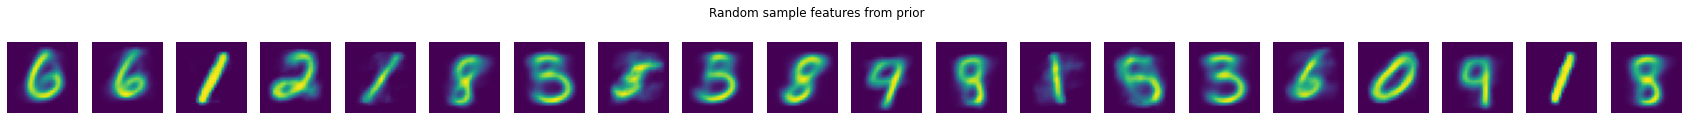

In [62]:
random_prior_features = nd.random_normal(loc=0, scale=1, shape=(n_images, 2), ctx=model_ctx)
x_mean, x_log_var = nd.split(vae_model.decoder(random_prior_features), 2, 1)

fig, ax = plt.subplots(1, n_images, figsize=(30, 5))
for i, x in enumerate(x_mean):
    ax[i].imshow(x.reshape((28,28)).asnumpy())
    ax[i].axis("off")
plt.suptitle('Random sampled features from prior', y=0.7)


* Evaluate the latent quality of the variational autoencoder: Scatter plot features of images, color code their labels.

*The latent space is clustered relatively well. The different overlapping clusters in the centre of the plot may well be caused by the similarity between the shape as with the 3 and the 8 etc.*

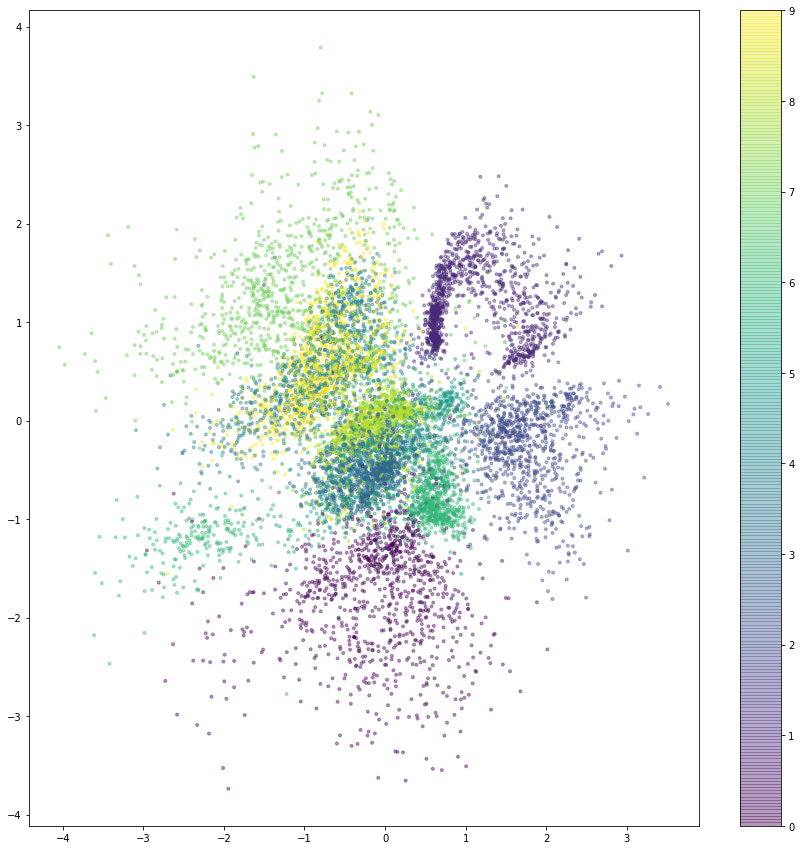

In [58]:
test_imgs = mx.ndarray.array(mnist['test_data'][:, 0]).as_in_context(model_ctx)
z_test = vae_model.encoder(test_imgs)

colors = np.array([mnist['test_label']])
plt.figure(figsize=(15, 15))
plt.scatter(z_test[:, 0].asnumpy(), z_test[:, 1].asnumpy(), c=colors, alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()